In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics import tsaplots

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout



import os
import json

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


[1. Loading  Data](#1)     
[2. Data Exploration](#2)  
[3. Stationarity Test](#3)  
[4. ARIMA Model](#4)  
[5. Prophet Model](#5)  
[6. Summary](#6)  

### <a id="1">1. Loading Data </a>

In [2]:
json_path = '../data/data_processed/BTCUSDT_final.json'

In [3]:
with open(json_path, 'r') as file:
    json_data = json.load(file)

In [4]:
data = json_data['data']

In [5]:
df = pd.DataFrame(data)
df['openTime'] = pd.to_datetime(df['openTime'])
df.set_index('openTime', inplace=True)
print(df.head(5))

                         open     high       low     close    volume  trend  \
openTime                                                                      
2024-11-19 12:00:00  91652.01  92788.0  90975.80  92391.99  13823.63      1   
2024-11-19 08:00:00  91620.00  91950.0  91200.00  91652.02   3730.95      1   
2024-11-19 04:00:00  91428.00  92000.0  91238.09  91620.01   3893.80      1   
2024-11-19 00:00:00  90464.07  91529.0  90357.00  91428.00   3575.27      1   
2024-11-18 20:00:00  90608.26  91980.0  90224.02  90464.08   7596.77     -1   

                     volume_price_ratio     BB_MA   BB_UPPER  BB_LOWER    RSI  \
openTime                                                                        
2024-11-19 12:00:00              0.1496  95694.52  100935.08  90453.96  26.08   
2024-11-19 08:00:00              0.0407  95334.03  100663.27  90004.79  25.56   
2024-11-19 04:00:00              0.0425  95002.75  100393.46  89612.04  28.06   
2024-11-19 00:00:00              0.0391  

### <a id="2">2. Data Exploration </a>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15893 entries, 2024-11-19 12:00:00 to 2017-08-17 04:00:00
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                15893 non-null  float64
 1   high                15893 non-null  float64
 2   low                 15893 non-null  float64
 3   close               15893 non-null  float64
 4   volume              15893 non-null  float64
 5   trend               15893 non-null  int64  
 6   volume_price_ratio  15893 non-null  float64
 7   BB_MA               15893 non-null  float64
 8   BB_UPPER            15893 non-null  float64
 9   BB_LOWER            15893 non-null  float64
 10  RSI                 15893 non-null  float64
 11  DOJI                15893 non-null  int64  
 12  HAMMER              15893 non-null  int64  
 13  SHOOTING_STAR       15893 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 1.8 MB


In [7]:
df.describe()

,open,high,low,close,volume,trend,volume_price_ratio,BB_MA,BB_UPPER,BB_LOWER,RSI,DOJI,HAMMER,SHOOTING_STAR
count,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000,15893.000000
mean,25888.534483,26139.402056,25622.328534,25894.134292,11451.817958,0.031397,0.746441,25939.288641,27026.127654,24852.449628,48.466736,0.130309,0.026301,0.015982
std,20299.783724,20480.943080,20113.616039,20305.891392,15065.942094,0.999538,0.996360,20346.499142,21147.027797,19583.271896,17.897223,0.336654,0.160034,0.125409
min,2870.900000,3148.000000,2817.000000,2919.000000,0.000000,-1.000000,0.000000,3244.470000,3307.170000,2984.580000,0.000000,0.000000,0.000000,0.000000
25%,8415.020000,8515.000000,8312.000000,8419.000000,4020.700000,-1.000000,0.138400,8440.630000,8884.350000,8013.050000,35.590000,0.000000,0.000000,0.000000
50%,19738.130000,19923.630000,19520.000000,19739.100000,6799.840000,1.000000,0.427300,19815.120000,20484.150000,18946.440000,48.640000,0.000000,0.000000,0.000000
75%,40862.460000,41370.990000,40410.750000,40864.730000,12278.900000,1.000000,0.968700,40809.900000,42822.230000,38812.920000,61.180000,0.000000,0.000000,0.000000
max,92540.000000,93265.640000,91238.090000,92540.010000,284711.690000,1.000000,22.861500,95694.520000,100935.080000,90453.960000,98.200000,1.000000,1.000000,1.000000


In [8]:
print('Date Min', df.index.min())
print('Date Max', df.index.min())

Date Min 2017-08-17 04:00:00
Date Max 2017-08-17 04:00:00


In [9]:
df = df.sort_index()
print(df.index.is_monotonic_increasing)
print(df.index.is_monotonic_decreasing)


True
False


In [10]:
df[df['volume']==0]


,open,high,low,close,volume,trend,volume_price_ratio,BB_MA,BB_UPPER,BB_LOWER,RSI,DOJI,HAMMER,SHOOTING_STAR
openTime,,,,,,,,,,,,,,
2017-09-06 16:00:00,4619.43,4619.43,4619.43,4619.43,0.0,-1,0.0,4470.11,4842.08,4098.14,65.85,1,0,0


In [11]:
df = df.drop(df[df['volume']==0].index)

In [12]:
df.describe()

,open,high,low,close,volume,trend,volume_price_ratio,BB_MA,BB_UPPER,BB_LOWER,RSI,DOJI,HAMMER,SHOOTING_STAR
count,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000,15892.000000
mean,25889.872836,26140.756195,25623.650136,25895.472997,11452.538561,0.031462,0.746488,25940.639583,27027.523579,24853.755588,48.465642,0.130254,0.026303,0.015983
std,20299.721226,20480.875992,20113.558797,20305.828927,15066.142228,0.999536,0.996374,20346.426499,21146.960892,19583.195957,17.897254,0.336594,0.160039,0.125413
min,2870.900000,3148.000000,2817.000000,2919.000000,5.890000,-1.000000,0.000100,3244.470000,3307.170000,2984.580000,0.000000,0.000000,0.000000,0.000000
25%,8418.410000,8518.397500,8312.750000,8419.405000,4020.737500,-1.000000,0.138400,8441.605000,8884.627500,8013.087500,35.590000,0.000000,0.000000,0.000000
50%,19738.615000,19926.815000,19522.185000,19739.440000,6800.040000,1.000000,0.427350,19816.650000,20485.100000,18947.690000,48.640000,0.000000,0.000000,0.000000
75%,40863.125000,41373.242500,40416.150000,40866.510000,12279.712500,1.000000,0.968750,40809.922500,42822.265000,38813.680000,61.180000,0.000000,0.000000,0.000000
max,92540.000000,93265.640000,91238.090000,92540.010000,284711.690000,1.000000,22.861500,95694.520000,100935.080000,90453.960000,98.200000,1.000000,1.000000,1.000000


<Axes: xlabel='openTime'>

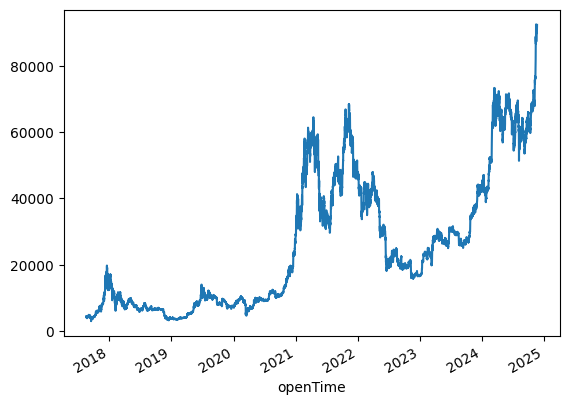

In [13]:
df['close'].plot()

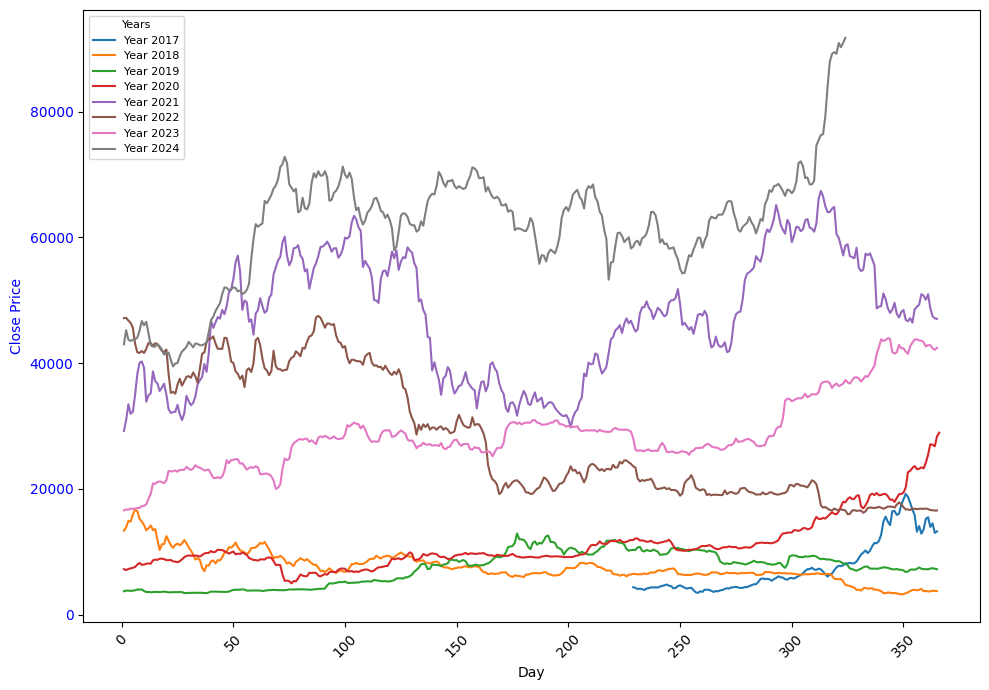

In [14]:
df_daily = df.resample('D').mean()
df_daily['DayOfYear'] = df_daily.index.dayofyear
df_daily['Year'] = df_daily.index.year  
fig, ax1 = plt.subplots(figsize=(10,7))

for year in df_daily['Year'].unique():
    df_year = df_daily[df_daily['Year'] == year]
    ax1.plot(df_year['DayOfYear'], df_year['close'], label=f'Year {int(year)}')

ax1.set_xlabel('Day')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

plt.xticks(rotation=45)
ax1.legend(title='Years', fontsize =8, title_fontsize=8, loc='upper left')

plt.tight_layout()
plt.show()

We are trying to see if there is any seasonal pattern, but from plot above we don't really see any seasonal pattern.

### <a id="3">3. Stationarity Test </a>

We perform an ADF test:

In [15]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries, autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [16]:
ADF_test(df["close"].values,'raw data')


 > Is the raw data stationary ?
Test statistic = 0.193
P-value = 0.972
Critical values :
	1%: -3.430762667009696 - The data is not stationary with 99% confidence
	5%: -2.86172238168374 - The data is not stationary with 95% confidence
	10%: -2.5668670772436846 - The data is not stationary with 90% confidence


The p-value exceeds the conventional significance level of 0.05 -> this indicates that the null hypothesis cannot be rejected. Data is non stationary.

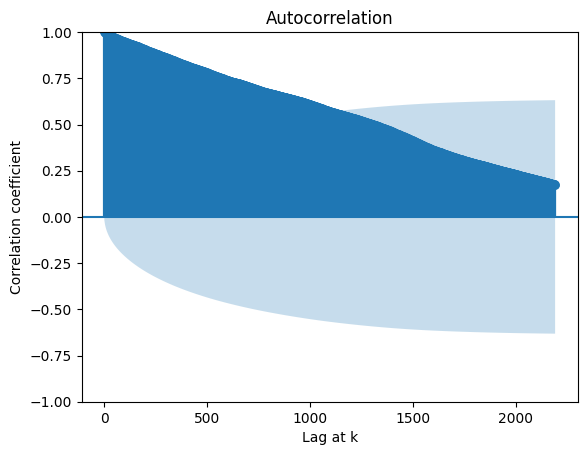

In [17]:
fig = tsaplots.plot_acf(df['close'], lags=2190)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

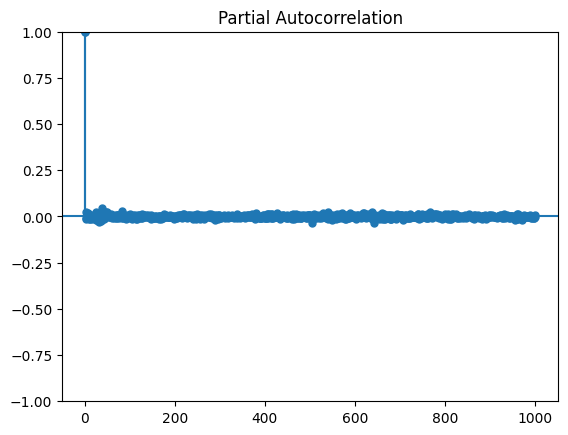

In [18]:
plot_pacf(df['close'], lags=1000)
plt.show()

ACF plot shows a decline, which indicates strong correlataion at the beginning. PACF shows spike at 1. It means that price is influenced by previous interval's price. The next step is to perform log transformation, as data is volatile. This will help to reduce outliers

<Axes: xlabel='openTime'>

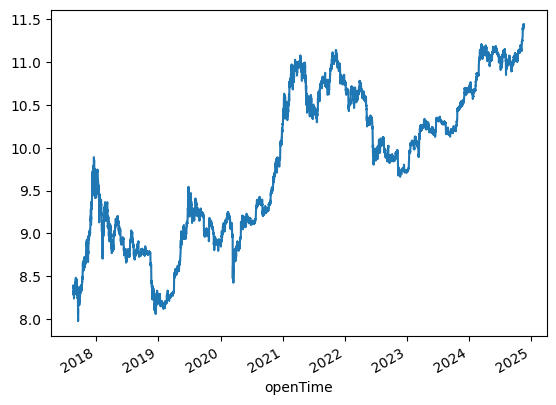

In [19]:
df['close_log']=np.log(df['close'])
df['close_log'].plot()

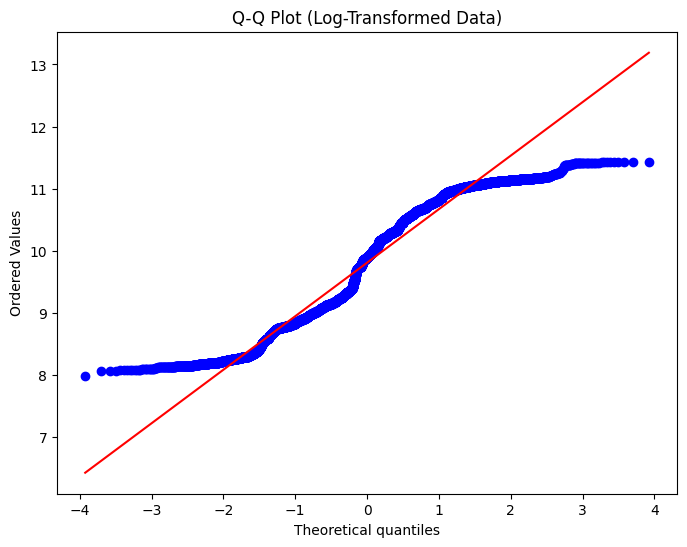

In [20]:
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(df['close_log'], dist="norm", plot=ax)
plt.title("Q-Q Plot (Log-Transformed Data)")
plt.show()

In [21]:
df['close_diff'] = df['close_log'].diff()
df = df.dropna(subset=['close_diff'])


<Axes: xlabel='openTime'>

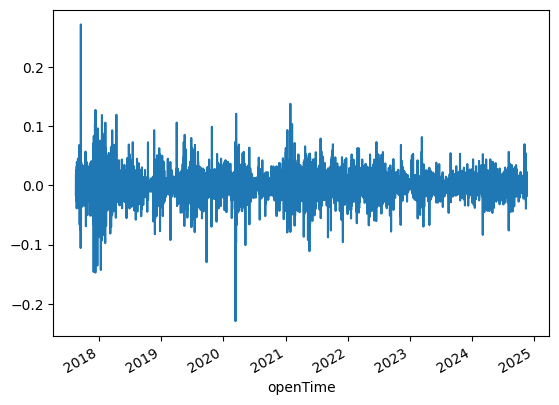

In [22]:
df["close_diff"].plot()

In [23]:
ADF_test(df["close_diff"].values,'raw data')

 > Is the raw data stationary ?
Test statistic = -20.394
P-value = 0.000
Critical values :
	1%: -3.43076248479874 - The data is  stationary with 99% confidence
	5%: -2.8617223011596566 - The data is  stationary with 95% confidence
	10%: -2.5668670343817426 - The data is  stationary with 90% confidence


<Axes: xlabel='openTime'>

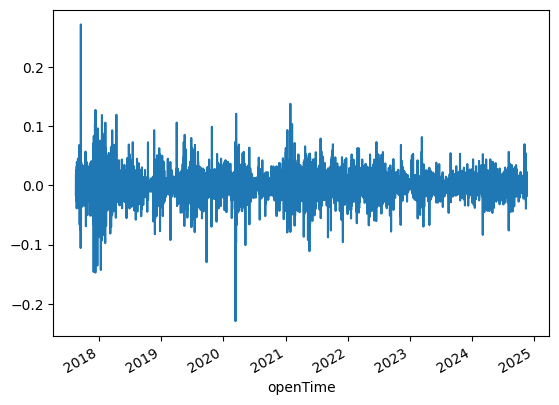

In [24]:
df['close_diff'].plot()

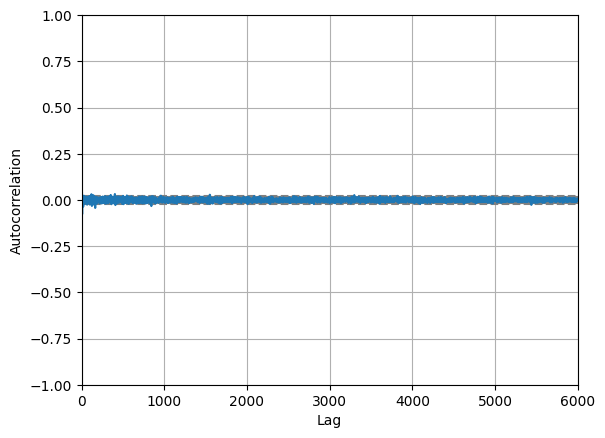

In [25]:
ax =autocorrelation_plot(df['close_diff'])
ax.set_xlim([0, 6000])
plt.show()

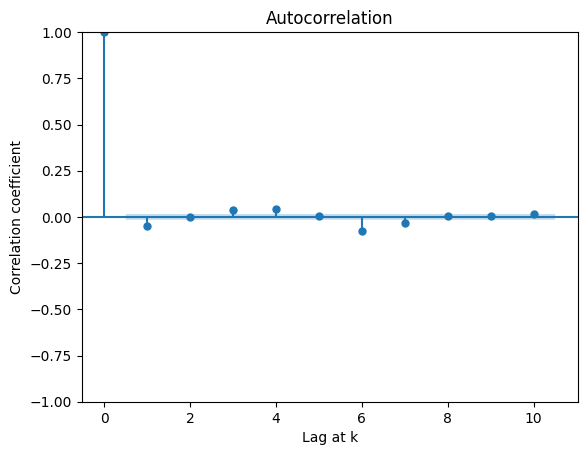

In [26]:
fig = tsaplots.plot_acf(df['close_diff'], lags=10)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

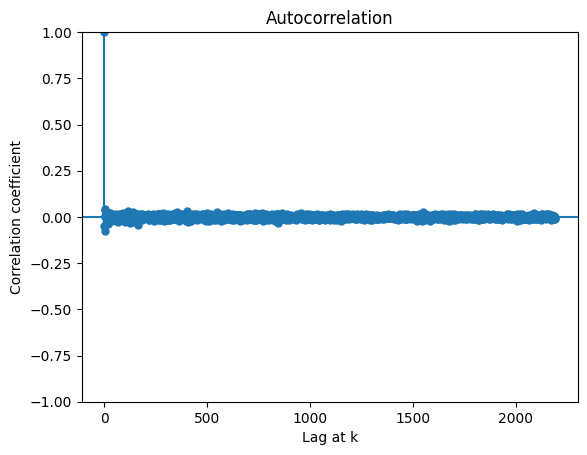

In [27]:
fig = tsaplots.plot_acf(df['close_diff'], lags=2190)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

### <a id="4">4. ARIMA Model </a>

In [28]:
interval = 10 #except for the last 10 intervals (4-hour periods), we can change this parameter
train_size = len(df) - interval  
train = df['close_diff'][:train_size]  
test = df['close_diff'][train_size:]

In [29]:
train = train.asfreq('4h')
test = test.asfreq('4h')

<Axes: xlabel='openTime'>

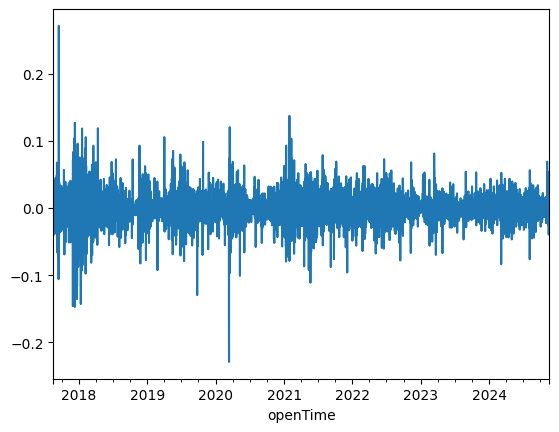

In [30]:
train.plot()

<Axes: xlabel='openTime'>

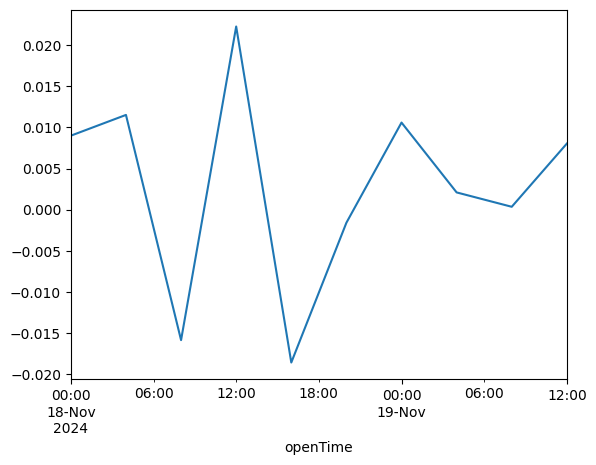

In [31]:
test.plot() #5 values

In [32]:
#First trying a simple model
model = ARIMA(train, order=(0, 1, 1))
arima = model.fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:                15898
Model:                 ARIMA(0, 1, 1)   Log Likelihood               43560.465
Date:                Mon, 23 Dec 2024   AIC                         -87116.930
Time:                        21:44:57   BIC                         -87101.583
Sample:                    08-17-2017   HQIC                        -87111.853
                         - 11-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.010   -104.253      0.000      -1.019      -0.981
sigma2         0.0002   2.41e-06    100.484      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  38.20   Jarque-

Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) help by comparing different chosen models. The model with the lower AIC or BIC score would be preferred.

In [33]:
forecast_log_diff = arima.forecast(steps=len(test))
forecast_log = np.cumsum(forecast_log_diff) + df['close_log'].iloc[train_size-1]
forecast_original = np.exp(forecast_log)
actual_values = df['close'].iloc[train_size:]

In [34]:
combined_table = pd.DataFrame({'Forecasted': forecast_original, 'Actual': actual_values})
print(combined_table)

                       Forecasted    Actual
2024-11-18 00:00:00  89899.062122  90668.58
2024-11-18 04:00:00  89942.154891  91719.90
2024-11-18 08:00:00  89985.268316  90275.13
2024-11-18 12:00:00  90028.402408  92309.51
2024-11-18 16:00:00  90071.557176  90608.26
2024-11-18 20:00:00  90114.732629  90464.08
2024-11-19 00:00:00  90157.928779  91428.00
2024-11-19 04:00:00  90201.145635  91620.01
2024-11-19 08:00:00  90244.383206  91652.02
2024-11-19 12:00:00  90287.641503  92391.99


We add one more actual value (to compare to forecasted value)

In [35]:
first_actual_index = df.index[train_size-1]
first_actual_value = df['close'].iloc[train_size-1]
first_row = pd.DataFrame({'Forecasted': [None],'Actual': [first_actual_value]}, index=[first_actual_index])
combined_table = pd.concat([first_row, combined_table])
print(combined_table)

                       Forecasted    Actual
2024-11-17 20:00:00           NaN  89855.99
2024-11-18 00:00:00  89899.062122  90668.58
2024-11-18 04:00:00  89942.154891  91719.90
2024-11-18 08:00:00  89985.268316  90275.13
2024-11-18 12:00:00  90028.402408  92309.51
2024-11-18 16:00:00  90071.557176  90608.26
2024-11-18 20:00:00  90114.732629  90464.08
2024-11-19 00:00:00  90157.928779  91428.00
2024-11-19 04:00:00  90201.145635  91620.01
2024-11-19 08:00:00  90244.383206  91652.02
2024-11-19 12:00:00  90287.641503  92391.99


/var/folders/6y/320ysdx901vcfjnckd85f41c0000gn/T/ipykernel_16196/1637051658.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_table = pd.concat([first_row, combined_table])


Lets evaluate the metrics:

In [36]:
def print_metrics(actual_values, forecast_original):
    mae = mean_absolute_error(actual_values, forecast_original)
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_original))
    mape = np.mean(np.abs((actual_values - forecast_original) / actual_values)) * 100
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

In [37]:
print_metrics(actual_values, forecast_original)

Mean Absolute Error (MAE): 1220.52
Root Mean Squared Error (RMSE): 1395.93
Mean Absolute Percentage Error (MAPE): 1.33%


Lets look at different ranges for p and q, while differencing is set at 1

In [38]:
p_range = range(0, 5)
q_range = range(0, 5) 
results = []

for p in p_range:
    for q in q_range:
            try:
                model = ARIMA(train, order=(p, 1, q))
                #The maxiter parameter specifies the max number of iterations the optimizer will run to estimate the model's parameters
                arima = model.fit(method_kwargs={'maxiter':500})
                
                #Forecast
                forecast_log_diff = arima.forecast(steps=len(test))
                forecast_log = np.cumsum(forecast_log_diff) + df['close_log'].iloc[train_size-1]
                forecast_original = np.exp(forecast_log)
                
                #Actual values
                actual_values = df['close'].iloc[train_size:]
                
                #Error metrics
                mae = mean_absolute_error(actual_values, forecast_original)
                rmse = np.sqrt(mean_squared_error(actual_values, forecast_original))
                mape = np.mean(np.abs((actual_values - forecast_original) / actual_values)) * 100
                results.append([p, q, mae, rmse, mape, arima.aic, arima.bic])
            
            except Exception as e:
                #In case of error - store NaNs
                results.append([p, q, np.nan, np.nan, np.nan, np.nan, np.nan])

results = pd.DataFrame(results, columns=['p', 'q', 'MAE', 'RMSE', 'MAPE','AIC', 'BIC']).sort_values(by='MAPE', ascending=True)
print(results)

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

    p  q          MAE         RMSE      MAPE           AIC           BIC
18  3  3  1076.714075  1267.762158  1.173604 -87154.749345 -87101.032145
19  3  4  1116.158312  1300.102217  1.216773 -87109.782422 -87048.391337
13  2  3  1138.694728  1318.334859  1.241461 -87140.317633 -87094.274318
24  4  4  1157.698244  1334.665589  1.262229 -87162.732163 -87093.667192
14  2  4  1189.016610  1366.310354  1.296445 -87153.872196 -87100.154996
3   0  3  1199.012661  1376.269932  1.307365 -87151.512859 -87120.817317
11  2  1  1206.367281  1383.352118  1.315402 -87151.208091 -87120.512548
2   0  2  1206.568860  1383.586098  1.315621 -87153.043439 -87130.021781
6   1  1  1208.102950  1384.978903  1.317299 -87153.204051 -87130.182394
1   0  1  1220.520333  1395.925554  1.330896 -87116.930370 -87101.582599
12  2  2  1237.198960  1410.541108  1.349148 -87151.624903 -87113.255475
7   1  2  1240.619742  1416.729797  1.352835 -87114.955832 -87084.260290
16  3  1  1245.561614  1418.269691  1.358307 -87173

Best p and q:

In [39]:
best_model = results.sort_values('MAPE').iloc[0]
best_p, best_q = int(best_model['p']), int(best_model['q'])
print(best_p,best_q)

3 3


In [40]:
model = ARIMA(train, order=(best_p, 1, best_q))
arima = model.fit()
forecast_log_diff = arima.forecast(steps=len(test))
forecast_log = np.cumsum(forecast_log_diff) + df['close_log'].iloc[train_size-1]
forecast_original = np.exp(forecast_log)
actual_values = df['close'].iloc[train_size:]

df_combined = pd.DataFrame({'Forecasted': forecast_original, 'Actual': actual_values})

first_actual_index = df.index[train_size-1]
first_actual_value = df['close'].iloc[train_size-1]
first_row = pd.DataFrame({'Forecasted': [None],'Actual': [first_actual_value]}, index=[first_actual_index])
df_combined = pd.concat([first_row, df_combined])
print(df_combined)


/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                       Forecasted    Actual
2024-11-17 20:00:00           NaN  89855.99
2024-11-18 00:00:00  90027.694632  90668.58
2024-11-18 04:00:00  90206.637429  91719.90
2024-11-18 08:00:00  90417.340671  90275.13
2024-11-18 12:00:00  90560.237538  92309.51
2024-11-18 16:00:00  90751.686634  90608.26
2024-11-18 20:00:00  90954.292319  90464.08
2024-11-19 00:00:00  91099.367391  91428.00
2024-11-19 04:00:00  91299.255549  91620.01
2024-11-19 08:00:00  91493.664498  91652.02
2024-11-19 12:00:00  91643.186799  92391.99


/var/folders/6y/320ysdx901vcfjnckd85f41c0000gn/T/ipykernel_16196/650845759.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([first_row, df_combined])


In [41]:
df_combined['Actual_prev'] = df_combined['Actual'].shift(1)
df_combined['trend_forecasted'] = (df_combined['Forecasted'] > df_combined['Actual_prev']).astype(int).replace({0: -1, 1: 1})
df_combined['trend_actual'] = (df_combined['Actual'] > df_combined['Actual_prev']).astype(int).replace({0: -1, 1: 1})
df_combined = df_combined.drop('Actual_prev', axis=1)
print(df_combined)


                       Forecasted    Actual  trend_forecasted  trend_actual
2024-11-17 20:00:00           NaN  89855.99                -1            -1
2024-11-18 00:00:00  90027.694632  90668.58                 1             1
2024-11-18 04:00:00  90206.637429  91719.90                -1             1
2024-11-18 08:00:00  90417.340671  90275.13                -1            -1
2024-11-18 12:00:00  90560.237538  92309.51                 1             1
2024-11-18 16:00:00  90751.686634  90608.26                -1            -1
2024-11-18 20:00:00  90954.292319  90464.08                 1            -1
2024-11-19 00:00:00  91099.367391  91428.00                 1             1
2024-11-19 04:00:00  91299.255549  91620.01                -1             1
2024-11-19 08:00:00  91493.664498  91652.02                -1             1
2024-11-19 12:00:00  91643.186799  92391.99                -1             1


Checking residuals (to ensure there are no patterns, looking for constant mean and variance)

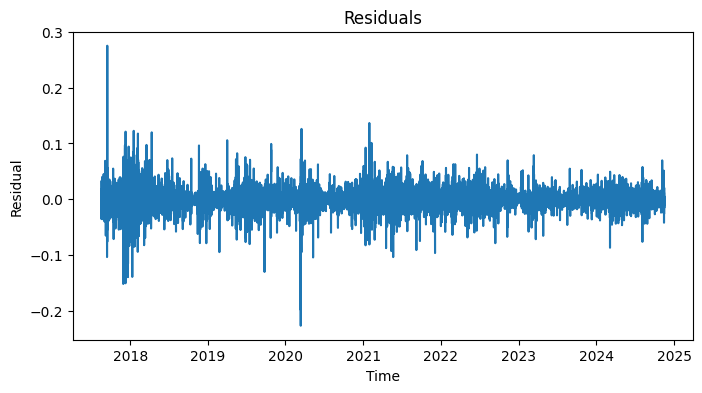

In [42]:
residuals = arima.resid
plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

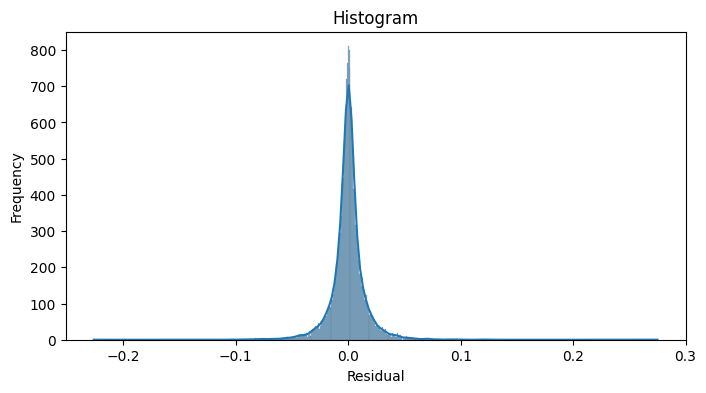

In [43]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

ARIMA models are univariate -> they forecast future values of the series itself based on past values. There are however external factors (global economy, law changes, social media, or technological advancements, etc) that can have an impact on the price and returns of cryptocurrency. The model does not capture these factors. More advanced models are recommended.

### Model Training - other models

In [44]:
#train, test = train_test_split(df, shuffle=False, test_size=0.2)
#print(train.index.min(), train.index.max())
#print(test.index.min(), test.index.max())

In [45]:
print(train)

openTime
2017-08-17 08:00:00    0.017616
2017-08-17 12:00:00   -0.017076
2017-08-17 16:00:00   -0.006248
2017-08-17 20:00:00   -0.009326
2017-08-18 00:00:00    0.001704
                         ...   
2024-11-17 04:00:00    0.003351
2024-11-17 08:00:00    0.001472
2024-11-17 12:00:00   -0.004689
2024-11-17 16:00:00   -0.002396
2024-11-17 20:00:00   -0.002090
Freq: 4h, Name: close_diff, Length: 15898, dtype: float64


In [46]:
y_train=train['close']
X_train=train.drop(['close'],axis=1)
y_test=test['close']
X_test=test.drop(['close'],axis=1)

KeyError: 'close'

In [155]:
print(y_test)

openTime
2023-06-08 20:00:00    26498.61
2023-06-09 00:00:00    26483.70
2023-06-09 04:00:00    26493.43
2023-06-09 08:00:00    26610.19
2023-06-09 12:00:00    26477.37
                         ...   
2024-11-18 20:00:00    90464.08
2024-11-19 00:00:00    91428.00
2024-11-19 04:00:00    91620.01
2024-11-19 08:00:00    91652.02
2024-11-19 12:00:00    92391.99
Name: close, Length: 3179, dtype: float64


### <a id="5">5. Prophet Model </a>

FB Prophet does not require stationarity tests, log transformations,differencing of the data. Algorithm can handle raw time-series data.

In [180]:
interval = 10 #except for the last 10 intervals (4-hour periods), we can change this parameter
prophet_df = pd.DataFrame({'ds': df.index,'y': df['close']})
train_size = len(prophet_df) - interval  

train_data = prophet_df.iloc[:train_size]
test_data = prophet_df.iloc[train_size:]

train_data['y'] = np.log(train_data['y'])
test_data['y'] = np.log(test_data['y'])

print(test_data)

                                     ds          y
openTime                                          
2024-11-18 00:00:00 2024-11-18 00:00:00  11.414966
2024-11-18 04:00:00 2024-11-18 04:00:00  11.426495
2024-11-18 08:00:00 2024-11-18 08:00:00  11.410617
2024-11-18 12:00:00 2024-11-18 12:00:00  11.432902
2024-11-18 16:00:00 2024-11-18 16:00:00  11.414301
2024-11-18 20:00:00 2024-11-18 20:00:00  11.412708
2024-11-19 00:00:00 2024-11-19 00:00:00  11.423307
2024-11-19 04:00:00 2024-11-19 04:00:00  11.425405
2024-11-19 08:00:00 2024-11-19 08:00:00  11.425754
2024-11-19 12:00:00 2024-11-19 12:00:00  11.433796


/var/folders/6y/320ysdx901vcfjnckd85f41c0000gn/T/ipykernel_663/2783334048.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y'] = np.log(train_data['y'])
/var/folders/6y/320ysdx901vcfjnckd85f41c0000gn/T/ipykernel_663/2783334048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y'] = np.log(test_data['y'])


In [181]:
model = Prophet()
model.fit(train_data)
future = model.make_future_dataframe(periods=len(test_data), freq='4H')
forecast = model.predict(future)
forecast_test = forecast.iloc[-len(test_data):][['ds', 'yhat']]
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
print(forecast_test)

12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds          yhat
15881 2024-11-18 00:00:00  79879.529943
15882 2024-11-18 04:00:00  79977.067446
15883 2024-11-18 08:00:00  80044.176953
15884 2024-11-18 12:00:00  80139.017988
15885 2024-11-18 16:00:00  80222.241914
15886 2024-11-18 20:00:00  80332.944529
15887 2024-11-19 00:00:00  80310.416791
15888 2024-11-19 04:00:00  80363.277621
15889 2024-11-19 08:00:00  80371.084065
15890 2024-11-19 12:00:00  80406.017119


In [171]:
future = model.make_future_dataframe(periods=len(test_data), freq='4H')
forecast = model.predict(future)
forecast_test = forecast.iloc[-len(test_data):][['ds', 'yhat']]
print(forecast_test)

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds          yhat
15881 2024-11-18 00:00:00  73624.970269
15882 2024-11-18 04:00:00  73660.229839
15883 2024-11-18 08:00:00  73691.936191
15884 2024-11-18 12:00:00  73717.305264
15885 2024-11-18 16:00:00  73741.035956
15886 2024-11-18 20:00:00  73774.310519
15887 2024-11-19 00:00:00  73763.305162
15888 2024-11-19 04:00:00  73780.129439
15889 2024-11-19 08:00:00  73790.795391
15890 2024-11-19 12:00:00  73796.966182


In [182]:
y_actual = test_data['y'].values
y_predicted = forecast_test['yhat'].values

# Metrics
mae = mean_absolute_error(y_actual, y_predicted)
rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
mape = np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 80193.15541171483
RMSE: 80193.34801759613
MAPE: 702092.2464349302%


Text(0.5, 1.0, 'Model Fit on Training Data')

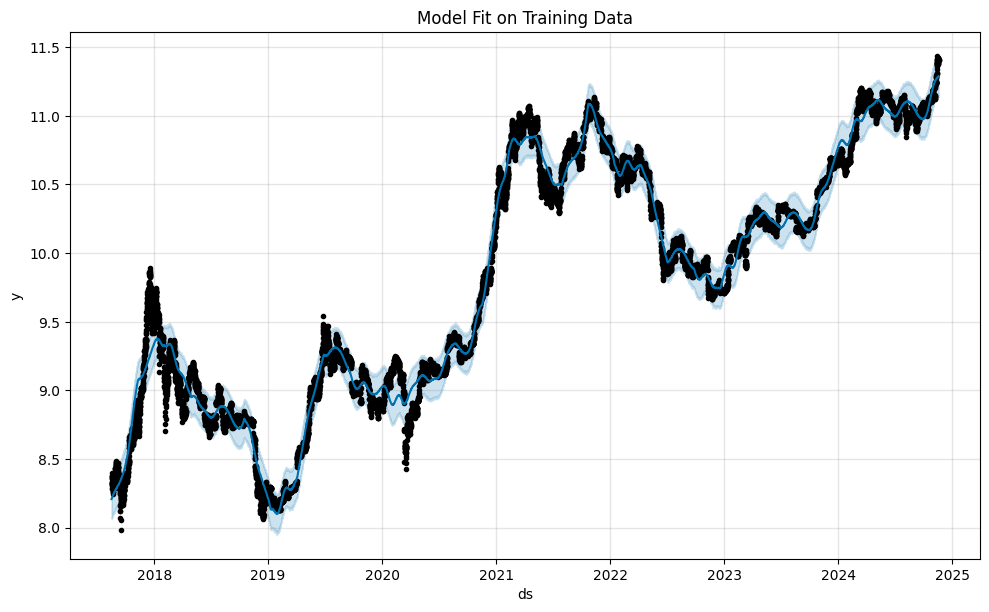

In [186]:
model.plot(model.predict(train_data))
plt.title("Model Fit on Training Data")

Data trends in this time series seem to be too inconsistent (Prophet mostly assumes smooth trends). FB Prophet is more used for time-series data with clear seasonality and trends, especially for business applications.

### LSTM (Long Short-Term Memory network)

LSTMs are sensitive to the scale of the input data, thus we normalize our data. We use for this model all the columns in the dataset:

In [52]:
#Normalizing the data using min max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[["open","high","low","volume","trend","volume_price_ratio","BB_MA","BB_UPPER","BB_LOWER","RSI"]])
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_data_y = scaler_y.fit_transform(df[["close"]])

In [53]:
interval = 10 #except for the last 10 intervals (4-hour periods), we can change this parameter
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data_y, test_size=interval/len(df), random_state=42, shuffle=False)

In [54]:
X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test), np.array(y_train), np.array(y_test)

The input to an LSTM network typically consists of a 3D tensor with the shape (batch_size, timesteps, input_features).
- Samples: number of individual data points in the dataset
- Time steps : the number of data points in each sequence. It determines how far back in time the model looks when making predictions.
- Features : the number of features

In [55]:
# Reshape input to be 3D (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [56]:
X_train.shape

(15881, 10, 1)

In [57]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [58]:
y_train.shape

(15881, 1)

In [62]:
def model_builder(hp):
    model = Sequential()
    
    #Input Layer
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True, input_shape= ( X_train.shape[1],X_train.shape[2])))
    
    #Hidden Layers
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    #Final LSTM layer
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    #Dropout
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    #Dense Layers
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [63]:
#Hyperparameter tuning   
tuner = kt.RandomSearch(model_builder, 
                        objective="mse", 
                        max_trials = 5, 
                        executions_per_trial = 2, 
                        directory = "./")
tuner.search(x=X_train, 
             y=y_train, 
             epochs = 10, 
             batch_size =256, 
             validation_data=(X_test, y_test))

Trial 4 Complete [00h 04m 15s]
mse: 0.0001013399196381215

Best mse So Far: 8.895559949451126e-05
Total elapsed time: 00h 14m 24s


In [94]:
best_model = tuner.get_best_models(num_models=1)[0]

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [95]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 128
n_layers: 3
lstm_0_units: 384
layer_2_neurons: 384
Dropout_rate: 0.1
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
Score: 8.895559949451126e-05

Trial 3 summary
Hyperparameters:
input_unit: 352
n_layers: 4
lstm_0_units: 192
layer_2_neurons: 160
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 256
lstm_2_units: 256
lstm_3_units: 32
Score: 0.0001013399196381215

Trial 2 summary
Hyperparameters:
input_unit: 128
n_layers: 1
lstm_0_units: 416
layer_2_neurons: 256
Dropout_rate: 0.2
dense_activation: sigmoid
lstm_1_units: 352
lstm_2_units: 64
Score: 0.0002967098625958897

Trial 1 summary
Hyperparameters:
input_unit: 384
n_layers: 2
lstm_0_units: 32
layer_2_neurons: 448
Dropout_rate: 0.0
dense_activation: relu
lstm_1_units: 96
lstm_2_units: 480
Score: 0.11652866005897522


In [96]:
y_pred = best_model.predict(X_test)
y_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


(10, 1)

In [97]:
y_pred = scaler_y.inverse_transform(y_pred)
valid = pd.DataFrame(y_test)
valid['Predicted'] = y_pred

In [99]:
results_lstm = pd.DataFrame({
    'Date': df.index[-interval:],  # Use the last 'interval' dates for the test set
    'Actual': y_test.flatten(),
    'Forecasted': np.round(y_pred.flatten(),2)
})
print(results_lstm)

                 Date    Actual    Forecasted
0 2024-11-18 00:00:00  90668.58  92210.218750
1 2024-11-18 04:00:00  91719.90  93113.921875
2 2024-11-18 08:00:00  90275.13  92408.156250
3 2024-11-18 12:00:00  92309.51  92968.320312
4 2024-11-18 16:00:00  90608.26  92789.343750
5 2024-11-18 20:00:00  90464.08  91854.132812
6 2024-11-19 00:00:00  91428.00  92744.476562
7 2024-11-19 04:00:00  91620.01  93441.109375
8 2024-11-19 08:00:00  91652.02  93507.500000
9 2024-11-19 12:00:00  92391.99  93874.460938


In [100]:
results_lstm['Actual_prev'] = results_lstm['Actual'].shift(1)
results_lstm['trend_forecasted'] = (results_lstm['Forecasted'] > results_lstm['Actual_prev']).astype(int).replace({0: -1, 1: 1})
results_lstm['trend_actual'] = (results_lstm['Actual'] > results_lstm['Actual_prev']).astype(int).replace({0: -1, 1: 1})
results_lstm = results_lstm.drop('Actual_prev', axis=1)
print(results_lstm)

                 Date    Actual    Forecasted  trend_forecasted  trend_actual
0 2024-11-18 00:00:00  90668.58  92210.218750                -1            -1
1 2024-11-18 04:00:00  91719.90  93113.921875                 1             1
2 2024-11-18 08:00:00  90275.13  92408.156250                 1            -1
3 2024-11-18 12:00:00  92309.51  92968.320312                 1             1
4 2024-11-18 16:00:00  90608.26  92789.343750                 1            -1
5 2024-11-18 20:00:00  90464.08  91854.132812                 1            -1
6 2024-11-19 00:00:00  91428.00  92744.476562                 1             1
7 2024-11-19 04:00:00  91620.01  93441.109375                 1             1
8 2024-11-19 08:00:00  91652.02  93507.500000                 1             1
9 2024-11-19 12:00:00  92391.99  93874.460938                 1             1


Plotting Results

KeyError: "['close'] not in index"

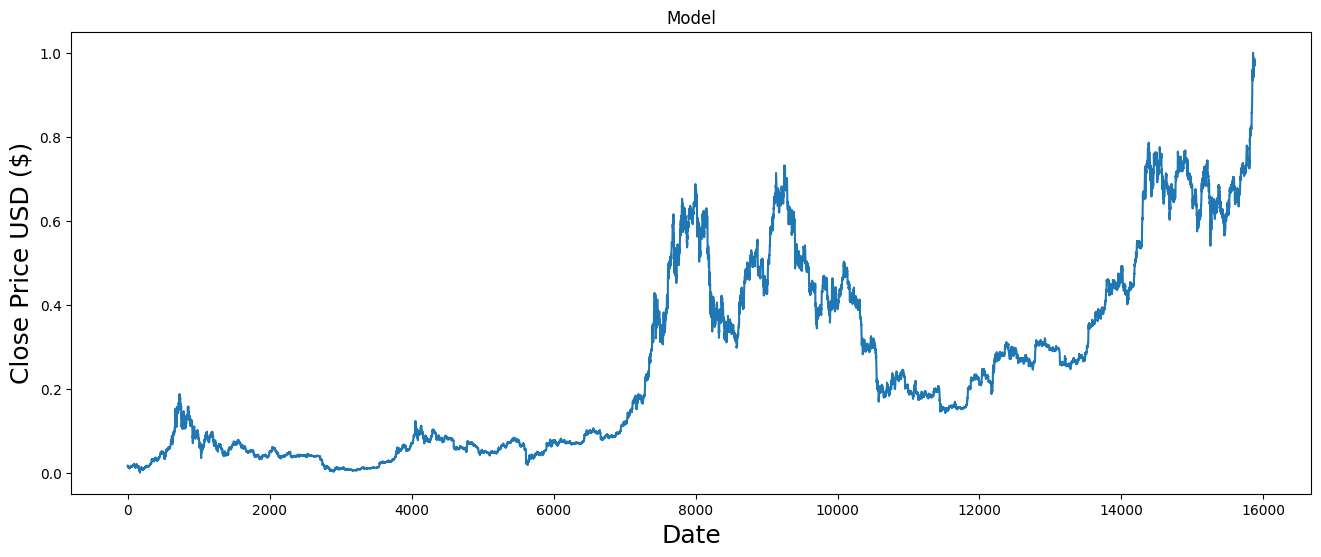

In [101]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_train)
plt.plot(valid[['close', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [223]:
# Build the LSTM model, activation function is 'relu,' and mean squared error (MSE) is the loss function.
model = Sequential([LSTM(50, activation='relu', input_shape=(n_steps, 1)), Dense(1)])
model.compile(optimizer='adam', loss='mse')

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [224]:
# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0)

In [225]:
# Predict on the test set
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [226]:
# Reverse scaling
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 950.0628749999975
RMSE: 1207.2040879815024


/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [227]:
results_lstm = pd.DataFrame({
    'Date': df.index[-interval:],  # Use the last 'interval' dates for the test set
    'Actual': y_test.flatten(),
    'Forecasted': y_pred.flatten()
})
print(results_lstm)


                 Date    Actual    Forecasted
0 2024-11-18 00:00:00  90668.58  89815.156250
1 2024-11-18 04:00:00  91719.90  90772.593750
2 2024-11-18 08:00:00  90275.13  91891.984375
3 2024-11-18 12:00:00  92309.51  90081.937500
4 2024-11-18 16:00:00  90608.26  92522.757812
5 2024-11-18 20:00:00  90464.08  90428.492188
6 2024-11-19 00:00:00  91428.00  90362.507812
7 2024-11-19 04:00:00  91620.01  91547.109375
8 2024-11-19 08:00:00  91652.02  91668.023438
9 2024-11-19 12:00:00  92391.99  91641.000000


In [228]:
results_lstm['Actual_prev'] = results_lstm['Actual'].shift(1)
results_lstm['trend_forecasted'] = (results_lstm['Forecasted'] > results_lstm['Actual_prev']).astype(int).replace({0: -1, 1: 1})
results_lstm['trend_actual'] = (results_lstm['Actual'] > results_lstm['Actual_prev']).astype(int).replace({0: -1, 1: 1})
results_lstm = results_lstm.drop('Actual_prev', axis=1)
print(results_lstm)


                 Date    Actual    Forecasted  trend_forecasted  trend_actual
0 2024-11-18 00:00:00  90668.58  89815.156250                -1            -1
1 2024-11-18 04:00:00  91719.90  90772.593750                 1             1
2 2024-11-18 08:00:00  90275.13  91891.984375                 1            -1
3 2024-11-18 12:00:00  92309.51  90081.937500                -1             1
4 2024-11-18 16:00:00  90608.26  92522.757812                 1            -1
5 2024-11-18 20:00:00  90464.08  90428.492188                -1            -1
6 2024-11-19 00:00:00  91428.00  90362.507812                -1             1
7 2024-11-19 04:00:00  91620.01  91547.109375                 1             1
8 2024-11-19 08:00:00  91652.02  91668.023438                 1             1
9 2024-11-19 12:00:00  92391.99  91641.000000                -1             1


In [230]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier

In [231]:
def grid_search(model_type, param_grid):
    regressor = KerasRegressor(build_fn= model_type, verbose=0)
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_.model, grid_search.best_params_

In [211]:

def evaluate_model(model, X_test, y_test, scaler, X_train_shape):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) #inverse the scaling
    
    original_copies_array = np.repeat(y_test, X_train.shape[2], axis=-1)
    original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(y_test), X_train.shape[2])))[:, 0]#inverse the scaling of testY

    mse = mean_squared_error(original_testY, predictions)
    rmse = np.sqrt(mse)
    return predictions, original_testY, mse, rmse

In [212]:
def create_stacked_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(interval, X_train.shape[2])))
    model.add(LSTM(units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

stacked_model = create_stacked_lstm_model(units=50, activation='relu')

# fit model
stacked_model.fit(X_train, y_train, epochs=200, verbose=0)

/Users/eliza/Documents/Cryptobot/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [213]:
# Define parameter grid
param_grid = {'units': [4, 20, 50],
              'batch_size' : [10, 20, 32, 40, 100],
              'epochs' : [10, 50, 100, 200]}

# Train and evaluate stacked LSTM
stacked_best_model, stacked_best_params = grid_search(create_stacked_lstm_model, param_grid)
stacked_pred, original_testY, stacked_mse, stacked_rmse = evaluate_model(stacked_best_model, X_test, y_test, scaler, X_train.shape)

NameError: name 'KerasRegressor' is not defined